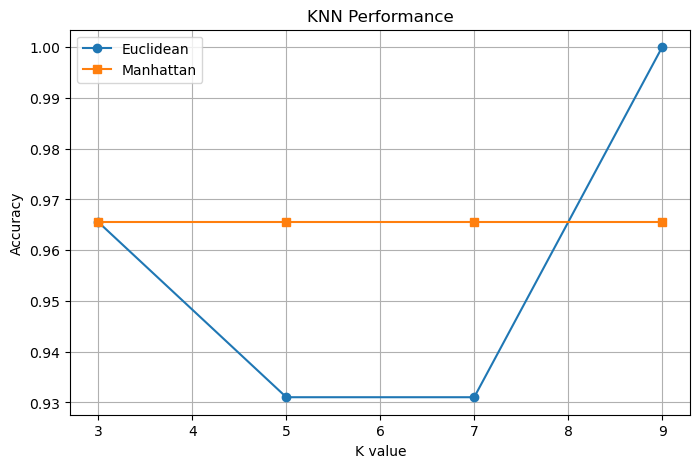


EUCLIDEAN - K=5
Accuracy: 0.931

Confusion Matrix:
                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa                7                0               0
Iris-versicolor            0                9               1
Iris-virginica             0                1              11

Precision, Recall, F1-score:
Iris-setosa: P=1.0, R=1.0, F1=1.0
Iris-versicolor: P=0.9, R=0.9, F1=0.9
Iris-virginica: P=0.9167, R=0.9167, F1=0.9167


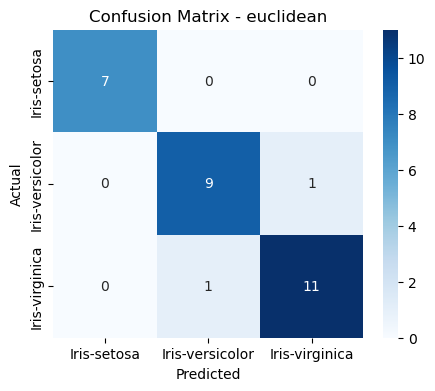


MANHATTAN - K=5
Accuracy: 0.9655

Confusion Matrix:
                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa                7                0               0
Iris-versicolor            0               10               0
Iris-virginica             0                1              11

Precision, Recall, F1-score:
Iris-setosa: P=1.0, R=1.0, F1=1.0
Iris-versicolor: P=0.9091, R=1.0, F1=0.9524
Iris-virginica: P=1.0, R=0.9167, F1=0.9565


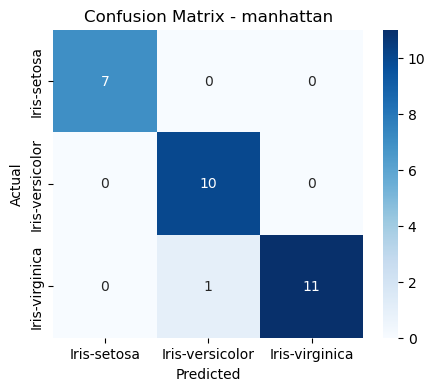

In [12]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# تحميل البيانات
df = pd.read_csv("iris.csv")

X = df[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].copy()
y = df['Species']

# معالجة البيانات

# حذف القيم المفقودة
X.dropna(inplace=True)
y = y[X.index]

# حذف الصفوف المكررة
X.drop_duplicates(inplace=True)
y = y[X.index]

# إزالة القيم الشاذة باستخدام IQR
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

mask = ~((X < (Q1 - 1.5*IQR)) | (X > (Q3 + 1.5*IQR))).any(axis=1)
X = X[mask]
y = y[mask]

# تقسيم البيانات إلى تدريب واختبار
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)

split = int(0.8 * len(X))
train_idx = indices[:split]
test_idx = indices[split:]

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

# تطبيع البيانات بدون تسريب معلومات
min_vals = X_train.min()
max_vals = X_train.max()

X_train = (X_train - min_vals) / (max_vals - min_vals)
X_test = (X_test - min_vals) / (max_vals - min_vals)

# دوال حساب المسافة
def euclidean_distance(p1, p2):
    return math.sqrt(sum((p1[i] - p2[i])**2 for i in range(len(p1))))

def manhattan_distance(p1, p2):
    return sum(abs(p1[i] - p2[i]) for i in range(len(p1)))

# تنفيذ خوارزمية KNN من الصفر
def predict_knn(X_train, y_train, X_test, k=3, distance='euclidean'):
    predictions = []
    
    X_train_values = X_train.values
    X_test_values = X_test.values
    
    for test_point in X_test_values:
        distances = []
        
        # حساب المسافة بين نقطة الاختبار وكل نقاط التدريب
        for j, train_point in enumerate(X_train_values):
            if distance == 'euclidean':
                dist = euclidean_distance(test_point, train_point)
            else:
                dist = manhattan_distance(test_point, train_point)
                
            distances.append((dist, y_train.iloc[j]))
        
        # ترتيب المسافات تصاعدياً
        distances.sort(key=lambda x: x[0])
        
        # اختيار أقرب k جيران
        k_neighbors = distances[:k]
        
        # التصويت بالأغلبية
        pred = Counter([neighbor[1] for neighbor in k_neighbors]).most_common(1)[0][0]
        predictions.append(pred)
        
    return predictions

# اختبار عدة قيم لـ K
k_values = [3,5,7,9]
results = {'euclidean': [], 'manhattan': []}

for k in k_values:
    for metric in ['euclidean','manhattan']:
        y_pred = predict_knn(X_train, y_train, X_test, k=k, distance=metric)
        accuracy = sum(y_test.iloc[i] == y_pred[i] for i in range(len(y_test))) / len(y_test)
        results[metric].append(accuracy)

plt.figure(figsize=(8,5))
plt.plot(k_values, results['euclidean'], marker='o', label='Euclidean')
plt.plot(k_values, results['manhattan'], marker='s', label='Manhattan')
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("KNN Performance")
plt.legend()
plt.grid(True)
plt.show()

# التقييم النهائي باستخدام أفضل قيمة لـ K
best_k = 5
classes = sorted(y.unique())

for metric in ['euclidean','manhattan']:
    
    y_pred = predict_knn(X_train, y_train, X_test, k=best_k, distance=metric)
    
    accuracy = sum(y_test.iloc[i] == y_pred[i] for i in range(len(y_test))) / len(y_test)
    
    class_to_index = {cls:i for i,cls in enumerate(classes)}
    num_classes = len(classes)
    
    # إنشاء مصفوفة الالتباس
    cm = [[0]*num_classes for _ in range(num_classes)]
    
    for i in range(len(y_test)):
        actual = class_to_index[y_test.iloc[i]]
        pred = class_to_index[y_pred[i]]
        cm[actual][pred] += 1
    
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    
    print(f"\n{metric.upper()} - K={best_k}")
    print("Accuracy:", round(accuracy,4))
    print("\nConfusion Matrix:")
    print(cm_df)
    
    print("\nPrecision, Recall, F1-score:")
    
    for i, cls in enumerate(classes):
        tp = cm[i][i]
        fp = sum(row[i] for row in cm) - tp
        fn = sum(cm[i]) - tp
        
        precision = tp / (tp+fp) if (tp+fp)!=0 else 0
        recall = tp / (tp+fn) if (tp+fn)!=0 else 0
        f1 = 2*precision*recall/(precision+recall) if (precision+recall)!=0 else 0
        
        print(f"{cls}: P={round(precision,4)}, R={round(recall,4)}, F1={round(f1,4)}")
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {metric}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

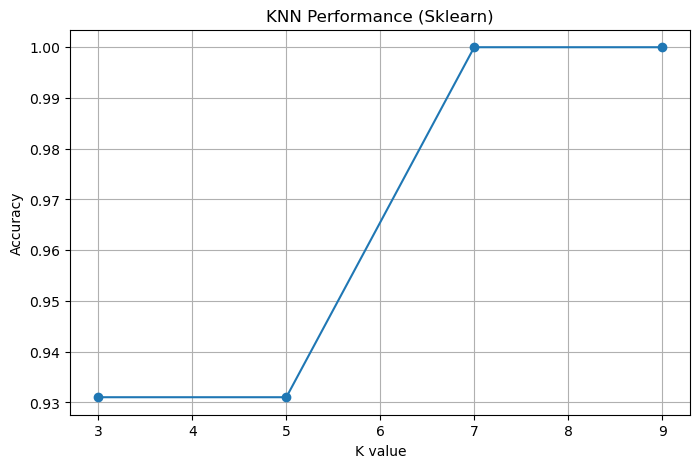


KNN (Sklearn) - K=5
Accuracy: 0.931
Precision: 0.9333
Recall: 0.9333
F1 Score: 0.9333

Confusion Matrix:
[[9 0 0]
 [0 9 1]
 [0 1 9]]


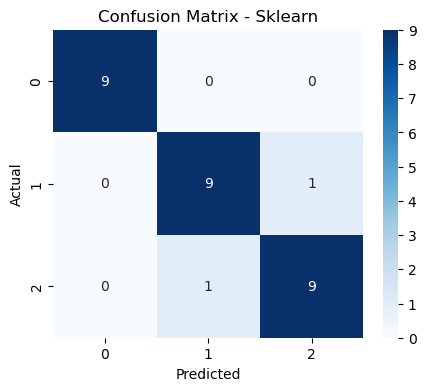

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# =========================
# 1) Load Data
# =========================
df = pd.read_csv("iris.csv")

X = df[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].copy()
y = df['Species']


# 2) Data Preprocessing

X.dropna(inplace=True)
y = y[X.index]

X.drop_duplicates(inplace=True)
y = y[X.index]

# Remove Outliers (IQR)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

mask = ~((X < (Q1 - 1.5*IQR)) | (X > (Q3 + 1.5*IQR))).any(axis=1)
X = X[mask]
y = y[mask]

# =========================
# 3) Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 4) Scaling (Correct Way)
# =========================
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# =========================
# 5) Test Different K
# =========================
k_values = [3,5,7,9]
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("KNN Performance (Sklearn)")
plt.grid(True)
plt.show()

# =========================
# 6) Final Model
# =========================
best_k = 5
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# =========================
# 7) Evaluation
# =========================
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)

print(f"\nKNN (Sklearn) - K={best_k}")
print("Accuracy:", round(accuracy,4))
print("Precision:", round(precision,4))
print("Recall:", round(recall,4))
print("F1 Score:", round(f1,4))
print("\nConfusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Sklearn")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()